### Nombre y Apellido: Kenet Chapeton 

# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


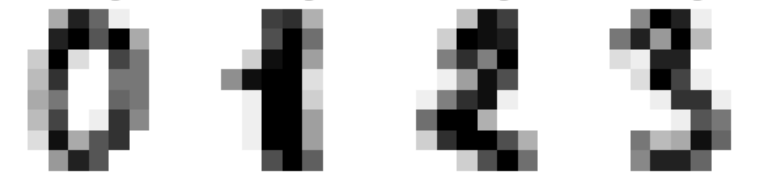



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

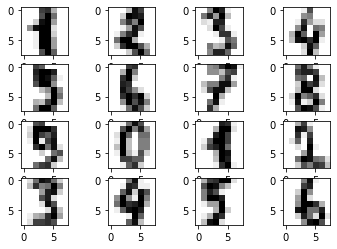

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


Vemos si hay un desbalance en las clases de nuestro dataset:

In [4]:
# Cargo los dígitos
#X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target
seed = 42

# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [6]:
# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y==0) | (y == 1)]

X_bin = X[bin_indices,:,:]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.33,
                                                    random_state=seed)
X_bin_train,X_bin_test,y_bin_train,y_bin_test=train_test_split(X_bin,
                                                    y_bin,
                                                    test_size=0.33,
                                                    random_state=seed)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print("Total de 0s para clasificación binaria: " + str(y_bin_test.shape[0] - y_bin_test.sum()))

Total de datos para clasificación entre 10 dígitos: 1797
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

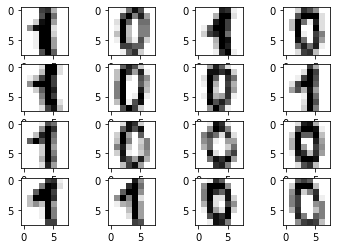

In [7]:
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(X_bin[i,:,:], cmap=plt.get_cmap('gray_r'))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

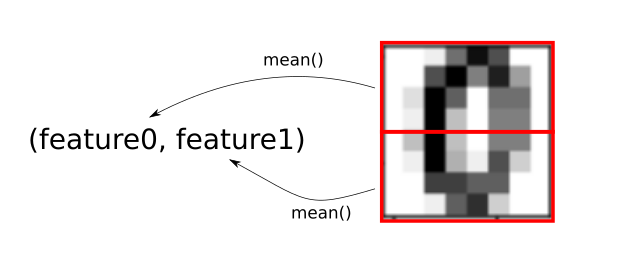

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

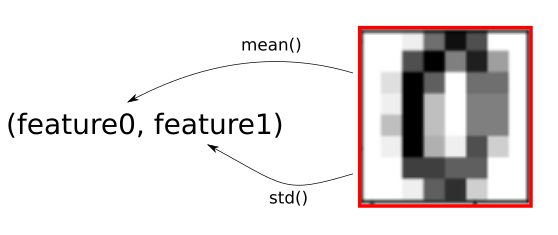


In [8]:
def extract_features_mean_std(x:np.ndarray):
    x_out = np.zeros(shape=(1,2))
    x_out[0,0] = np.mean(x)
    x_out[0,1] = np.std(x)
    return x_out

def extract_features_mean_top_bottom(x:np.ndarray):
    x_out = np.zeros(shape=(1,2))
    x_out = np.mean(x[:4,:]),np.mean(x[4:,:])
    return x_out

def preprocess_features_mean_std(X):
    X_pp = np.zeros(shape=(X.shape[0], 2))
    for i in range(X.shape[0]):
        X_pp[i,:] = extract_features_mean_std(X[i,:,:])
    return X_pp
  
def preprocess_features_mean_top_bottom(X):
    X_pp = np.zeros(shape=(X.shape[0], 2))
    for i in range(X.shape[0]):
        X_pp[i,:] = extract_features_mean_top_bottom(X[i,:,:])
    return X_pp

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

In [15]:
# Definimos un pereceptrón
clasificador = Perceptron(random_state=seed,
                          max_iter=1e3)

# Transformamos las features de los datos para el problema binario
X_bin_train_features = preprocess_features_mean_std(X_bin_train)
X_bin_test_features = preprocess_features_mean_std(X_bin_test)

#Transformacion features usando mean top bottom
X_bin_train_features2 = preprocess_features_mean_top_bottom(X_bin_train)
X_bin_test_features2 = preprocess_features_mean_top_bottom(X_bin_test)
# Entrenamos el clasificador
clasificador.fit(X_bin_train_features,y_bin_train)


# Imprimir la accuracy en los datos de test.
print("Accuracy en test: " + str(clasificador.score(X_bin_test_features,
                                                   y_bin_test)))
clasificador.fit(X_bin_train_features2,y_bin_train)
print("Accuracy en test para el 2do modelo: "+ str(clasificador.score(X_bin_test_features2,
                                                   y_bin_test)))
# Imprimir las predicciones realizadas para los datos de test

#print("Predictions: " + str(clasificador.predict(X_bin_train_features)))

Accuracy en test: 0.8739495798319328
Accuracy en test para el 2do modelo: 0.4957983193277311


# Visualizando las features

Para entender el grado de discriminabilidad que presentan nuestras features, vamos a visualizarlas. Para hacerlo, colorear los items de cada clase con un color diferente.

In [17]:
def graph_features(X:np.ndarray,y:np.ndarray): 
    #plt.figure()
    for i in range(np.unique(y).size):
        plt.scatter(X[y==i,0],X[y==i,1],label=f'Clase {i}')
    #plt.xlabel('mean-all')
    #plt.ylabel('std-all')
    plt.legend()
    #plt.title("Visualizacion de Caracteristicas de Clase (0-1)")
    #plt.show()

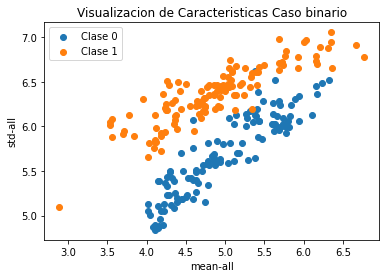

In [18]:
plt.figure()
graph_features(X_bin_train_features,y_bin_train)
plt.xlabel('mean-all')
plt.ylabel('std-all')
plt.legend()
plt.title("Visualizacion de Caracteristicas Caso binario")
plt.show()

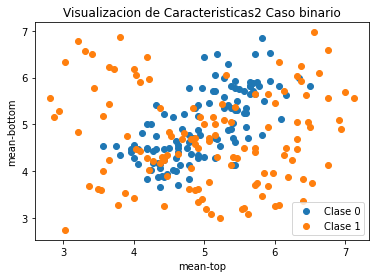

In [24]:
plt.figure()
graph_features(X_bin_train_features2,y_bin_train)
plt.xlabel('mean-top')
plt.ylabel('mean-bottom')
plt.legend()
plt.title("Visualizacion de Caracteristicas2 Caso binario")
plt.show()

Se puede observar que no pareciera haber una frontera de decision lineal, por lo que se esperaria que el accuracy no sea superior al modelo anterior. Se ve empiricamente dicha suposicion. 

# Complicando las cosas: 


Ahora volvemos al caso de 10 dígitos y probamos la misma estrategia que estábamos usando anteriormente.

In [20]:
# Definimos un pereceptrón
clasificador10 = Perceptron(random_state=seed,
                           max_iter=1e3)

X_train_features = preprocess_features_mean_std(X_train)
X_test_features = preprocess_features_mean_std(X_test)

clasificador10.fit(X_train_features,y_train)

# Imprimir la accuracy en los datos de test.
print("Accuracy en test: " + str(clasificador10.score(X_test_features,y_test)))

# Imprimir las predicciones realizadas para los datos de test
#print("Predictions: " + str(clasificador10.predict(X_test_features)))

Accuracy en test: 0.12289562289562289


Vamos a probar usando el otro tipo de extraccion de features:

In [21]:
# Definimos un pereceptrón
clas10 = Perceptron(random_state=seed,max_iter=1e3)

X_train_features2 = preprocess_features_mean_top_bottom(X_train)
X_test_features2 = preprocess_features_mean_top_bottom(X_test)

clas10.fit(X_train_features2,y_train)

# Imprimir la accuracy en los datos de test.
print("Accuracy en test: " + str(clasificador10.score(X_test_features2,y_test)))

# Imprimir las predicciones realizadas para los datos de test
#print("Predictions: " + str(clasificador10.predict(X_test_features)))

Accuracy en test: 0.04713804713804714


Para intentar entender por qué disminuye tan drásticamente la performance, visualicen las features de las 10 clases coloreando cada punto en un color diferente como hicimos anteriormente.

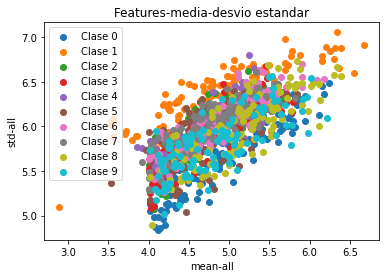

In [22]:
plt.figure()
graph_features(X_train_features,y_train)
plt.xlabel('mean-all')
plt.ylabel('std-all')
plt.legend()
plt.title("Features-media-desvio estandar")
plt.show()

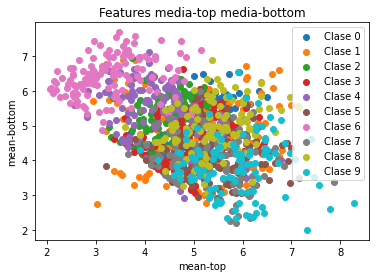

In [23]:
plt.figure()
graph_features(X_train_features2,y_train)
plt.xlabel('mean-top')
plt.ylabel('mean-bottom')
plt.legend()
plt.title("Features media-top media-bottom")
plt.show()

# Entregable:
* Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos? 

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



# Respuesta:

1.
La que mejor me funciono fue la extraccion de media y desvio estandar para el caso binario, se puede observar en los graficos correspondientes a la extraccion de features con media-top y bottom, no parecieran tener una frontera de decision lineal, tanto para el caso binario como el multicase, por lo que se esperaria que el accuracy no sea superior al modelo previamente mencionado. 
2.
Para el caso binario seria de $\frac{1}{2}=0.5$ y para el multicase de 10 clases, seria de $\frac{1}{10}=0.1$, de forma general si tenemos $n$ clases, el valor seria de $\frac{1}{n}, pues es consecuencia de que cada clase tiene la misma probabilidad de ser elegida. 

3.
Para el caso binario, usando la metrica accuracy, pareciera indicar que si pues dio un valor cercano a $0.87$ siendo mayor a $0.5$, sin embargo el modelo empleado para 10 clases dio un valor que ronda $0.1$ lo cual indica que funciono igual que un clasificador aleatorio.